# Feature importance

Today we'll talk about feature importance and feature selection. The dataset is the same one that we used during week 5 - [adult income dataset](https://archive.ics.uci.edu/dataset/2/adult).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import zipfile

pd.set_option('display.max_columns', None)

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
url = "https://archive.ics.uci.edu/static/public/2/adult.zip"
urllib.request.urlretrieve(url, "adult.zip")

with zipfile.ZipFile("adult.zip", "r") as zip_ref:
    zip_ref.extractall("adults")

columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

# the dataset is pre-split into train and test
# I want to do the split myself, so let's join the datasets
df1 = pd.read_csv("adult.data", header=None, names=columns)
# first row of adult.test is weird, let's remove it
df2 = pd.read_csv("adult.test", header=None, names=columns)[1:]
df = pd.concat([df1, df2])

In [3]:
# Helper function for plotting
def plot_importances(importances, features, xlabel="importance"):
    df = pd.DataFrame({
        'feature': features,
        'importance': importances
    })
    df = df.sort_values('importance', ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x='importance', y='feature', data=df)
    plt.xlabel(xlabel)


## Preprocessing

In [4]:
# Copying preprocessing from week 5
df = df.drop(columns=["fnlwgt"])
df = df.rename(columns=lambda x: x.replace("-", "_"))
# Replace "?" with NaN in all columns
df = df.replace(" ?", None)

# map target to more usable 0/1
df["income"] = df["income"].str.strip().str.replace(".", "")
df["income"] = df["income"].map({"<=50K": 0, ">50K": 1})

# Convert age column to integer type
df["age"] = df["age"].astype(int)


In [5]:
numerical_features = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]


In [6]:
df = df[numerical_features + ["income"]]

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
y_train, y_test, X_train, X_test = train_test_split(
    df["income"], df.drop(columns=["income"]), test_size=0.2, random_state=10
)

# Also split a fix validation set
y_train, y_val, X_train, X_val = train_test_split(
    y_train, X_train, test_size=0.25, random_state=10
)


## Feature Importance

Not every predictor we use in a model is equal - some have a lot of signal and contribute a lot to the prediction accuracy, and some barely matter or don't matter at all. More features means a more complex model, and additional complexity always has to be justified. Therefore, if we have features in a model that do not contribute to the model's accuracy, we'd rather remove the features.

Some algorithms, like random forests, give feature importances out of the box. 


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42)

Let's quickly check how good this model is.

In [9]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"Mean ROC AUC: {cv_scores.mean():.4f}")


Mean ROC AUC: 0.8626


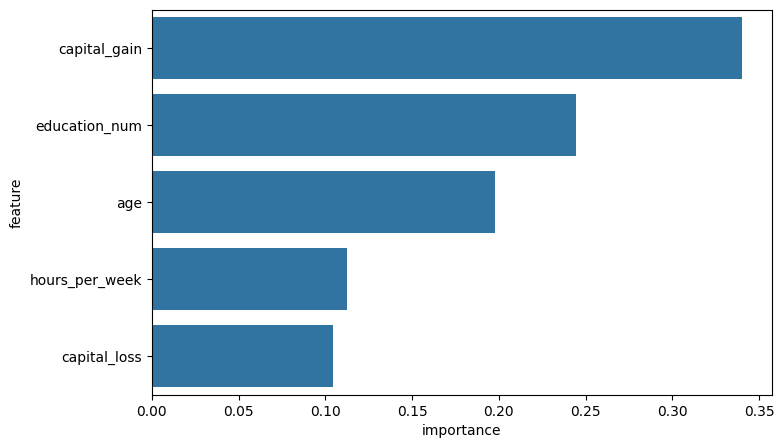

In [10]:
rf_model.fit(X_train, y_train)
plot_importances(rf_model.feature_importances_, X_train.columns)


It seems that of all features that we used in the mnodel, `capital_loss` and `hours_per_week` are the least important ones. So what happens if we remove those features from the model?

In [11]:
cv_scores_reduced = cross_val_score(
    rf_model,
    X_train.drop(["capital_loss", "hours_per_week"], axis=1),
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)

print(f"original: {cv_scores.mean():.4f}")
print(f"removed features: {cv_scores_reduced.mean():.4f}")


original: 0.8626
removed features: 0.8422


We can also check the impact to model's performance from removing the most important feature.

In [12]:
cv_scores_reduced = cross_val_score(
    rf_model,
    X_train.drop(["capital_gain"], axis=1),
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)

print(f"original: {cv_scores.mean():.4f}")
print(f"removed features: {cv_scores_reduced.mean():.4f}")


original: 0.8626
removed features: 0.8301


Average reduction in the criterion (in the case above - gini criterion) is a model-dependent way to calculate feature importances. One popular model-agnostic way to calculate feature importances is called permutation importance.

The algorithm goes roughly as follows:
1. Train the model on original dataset.
2. Evaluate the trained model via cross validation.
2. For each feature:
    1. Permute the feature - the single column in the dataset is randomly shuffled. This removes any association between the feature and the target variable.
    2. Make predictions and evaluate the model on the training data.
    3. Calculate the performance drop.


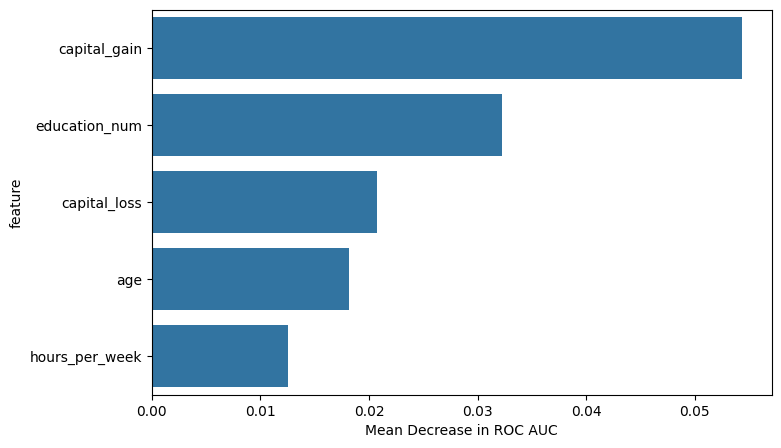

In [13]:
from sklearn.inspection import permutation_importance

prem_imp = permutation_importance(rf_model, X_val, y_val, n_repeats=10, n_jobs=-1)

plot_importances(
    prem_imp.importances_mean, X_val.columns, xlabel="Mean Decrease in ROC AUC"
)


### Task

Fit a Logistic Regression model with default hyperparameters. Calculate the feature importances of the model using permutation importance.

Also, think about the following - does Logistic Regression, like Random Forests, have a in-built feature importances? What is the closest that logistic regression has to feature importances?

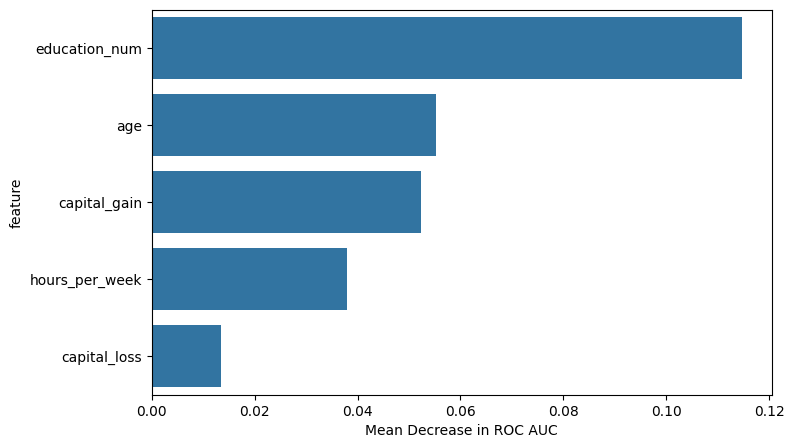

In [ ]:
# Answer
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

perm_imp = permutation_importance(
    lr_model, X_val, y_val, n_repeats=10, n_jobs=-1, scoring="roc_auc"
)

plot_importances(
    perm_imp.importances_mean, X_val.columns, xlabel="Mean Decrease in ROC AUC"
)

Logistic regression can also be considered to come with feature importances built in, however, there is a very important caveat.

### Task

Plot the coefficients of the logistic regression model we fitted above using `plot_importances`.

What do you see and why?


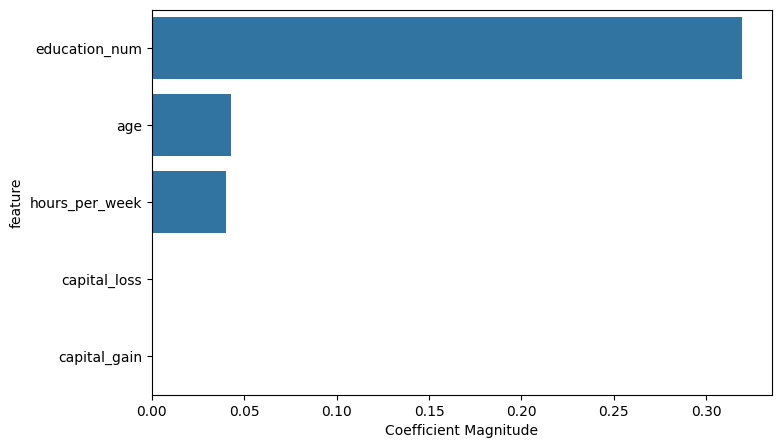

In [15]:
from sklearn.linear_model import LogisticRegression

plot_importances(np.abs(lr_model.coef_[0]), X_train.columns, xlabel="Coefficient Magnitude")


In [16]:
lr_model.coef_[0]

array([0.0426114 , 0.31948319, 0.00033978, 0.00063647, 0.03990867])

In [17]:
X_train.agg(["min", "max", "mean", "std"])

,age,education_num,capital_gain,capital_loss,hours_per_week
min,17.000000,1.000000,0.000000,0.000000,1.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000
mean,38.542895,10.071390,1073.906156,89.249898,40.402675
std,13.679714,2.576441,7422.751528,406.239263,12.403925


## Model Explainability

In logistic or linear regression, we can explain the models via coefficients - a coefficient basically says what impact a one-unit increase in the predictor has on the prediction value (log-odds in case of logistic regression). Decision trees are likewise quite transparent, since we can explain the value of a single prediction by going down the tree. However, the same cannot be said about random forests.

Having explainable models is important in sensitive domains such as medicine and banking, since there we not only care about having accurate decisions, but we also care about being able to explain why the model made a specific decision - models have to be auditable. However, there is a conflict here - interpretable models are less complex and are therefore less accurate than random forests or neural networks.

We call non-interpretable models black-box models - they are black boxes that receive data and output a prediction, but it's diffucult to udnerstand what's going on inside the algorithm. We also refer to interpretable models as glass-box models. Model-agnostic feature importances can be helpful here, but e.g. permutation importance is a *global* interpretability method and will not help us understand why a single prediction was made.


# ![Model Explainability](explainability.png)


